# SEP532 인공지능 이론과 실제
## Deep Learning Practice 
#### Prof. Ho-Jin Choi
#### School of Computing, KAIST

---

### Text classification with an RNN

Let's build text classification model with RNN on the IMDB dataset for sentiment analysis.

In [2]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

#### Setup input pipeline

The IMDB large movie review dataset is a binary classification dataset—all the reviews have either a positive or negative sentiment.

Download the dataset using [`TFDS`](https://www.tensorflow.org/datasets).
- Args of [`tfds.load`](https://www.tensorflow.org/datasets/api_docs/python/tfds/load):
    - `name`: str, the registered name of the DatasetBuilder.
    - `with_info`: bool, if True, tfds.load will return the tuple (tf.data.Dataset, tfds.core.DatasetInfo) containing the info associated with the builder.
    - `as_supervised`: bool, if True, the returned tf.data.Dataset will have a 2-tuple structure (input, label) according to builder.info.supervised_keys. If False, the default, the returned tf.data.Dataset will have a dictionary with all the features.

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [4]:
for example, label in train_dataset.take(1):
    print('text: ', example.numpy())
    print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these (text, label) pairs:

In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [6]:
for example, label in train_dataset.take(1):
    print('texts: ', example.numpy()[:3])
    print()
    print('labels: ', label.numpy()[:3])

texts:  [b"I caught a bit of this concert on public television and knew I had to have it. The boys give everyone at the Royal Albert an excellent, often thrilling performance complete in every way. Pure, too - no synth, no smoke-shrouded lasers and strobes, no grandiose entrance (and an unstoned, serious, and appreciative audience, all of whom left their bottle rockets at home).<br /><br />If you're a Cream fan (or if you've only heard of them); if you're a blues fan; if you're a rock 'n' roll fan; you will not be disappointed when you view and listen to this DVD. You also will never lose this DVD because you'll never lend it to anyone. (This DVD justifies selfishness! Tell them to get their own!) It's too good and too replayable; you'll want to keep it within easy reach."
 b"For loyal Duran Duran fans who want to watch a good music video, skip this one. The producers decided to get creative and make this 80's video something of a sci-fi story, involving the evil Barbarella villain fro

#### Create the text encoder
The raw text loaded by [`tfds`](https://www.tensorflow.org/datasets/api_docs/python/tfds) needs to be processed before it can be used in a model. The simplest way to process text for training is using the [`experimental.preprocessing.TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization) layer. This layer has many capabilities, but this practice sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt()` method:

In [7]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt()` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [8]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [9]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[10,  1,  4, ...,  0,  0,  0],
       [16,  1,  1, ...,  0,  0,  0],
       [ 2,  1,  5, ...,  0,  0,  0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:
1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is "`lower_and_strip_punctuation`".
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [10]:
for n in range(3):
    print("Original: ", example[n].numpy())
    print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
    print()

Original:  b"I caught a bit of this concert on public television and knew I had to have it. The boys give everyone at the Royal Albert an excellent, often thrilling performance complete in every way. Pure, too - no synth, no smoke-shrouded lasers and strobes, no grandiose entrance (and an unstoned, serious, and appreciative audience, all of whom left their bottle rockets at home).<br /><br />If you're a Cream fan (or if you've only heard of them); if you're a blues fan; if you're a rock 'n' roll fan; you will not be disappointed when you view and listen to this DVD. You also will never lose this DVD because you'll never lend it to anyone. (This DVD justifies selfishness! Tell them to get their own!) It's too good and too replayable; you'll want to keep it within easy reach."
Round-trip:  i [UNK] a bit of this [UNK] on [UNK] television and knew i had to have it the boys give everyone at the [UNK] [UNK] an excellent often [UNK] performance complete in every way [UNK] too no [UNK] no [UNK

#### Create the model
![A drawing of the information flow in the model](images/bidirectional.png)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.
2. The first layer is the `encoder`, which converts the text to a sequence of token indices.
3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors. This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.
4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep. The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 
    - The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  
    - The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.
5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 

The code to implement this is below:

In [11]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Compile the Keras model to configure the training process:

In [12]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

#### Train the model

In [13]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 29s 57ms/step - loss: 0.6828 - accuracy: 0.5113 - val_loss: 0.4692 - val_accuracy: 0.7542
Epoch 2/10
391/391 [==============================] - 21s 53ms/step - loss: 0.4141 - accuracy: 0.8040 - val_loss: 0.3589 - val_accuracy: 0.8354
Epoch 3/10
391/391 [==============================] - 21s 53ms/step - loss: 0.3444 - accuracy: 0.8460 - val_loss: 0.3535 - val_accuracy: 0.8547
Epoch 4/10
391/391 [==============================] - 21s 54ms/step - loss: 0.3126 - accuracy: 0.8656 - val_loss: 0.3262 - val_accuracy: 0.8542
Epoch 5/10
391/391 [==============================] - 21s 53ms/step - loss: 0.3091 - accuracy: 0.8659 - val_loss: 0.3465 - val_accuracy: 0.8599
Epoch 6/10
391/391 [==============================] - 21s 53ms/step - loss: 0.3078 - accuracy: 0.8728 - val_loss: 0.3220 - val_accuracy: 0.8557
Epoch 7/10
391/391 [==============================] - 21s 53ms/step - loss: 0.3031 - accuracy: 0.8681 - val_loss: 0.3259 - val_accuracy:

In [14]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 8s 21ms/step - loss: 0.3190 - accuracy: 0.8519
Test Loss: 0.3190028965473175
Test Accuracy: 0.8519200086593628


(0.0, 0.6554021760821342)

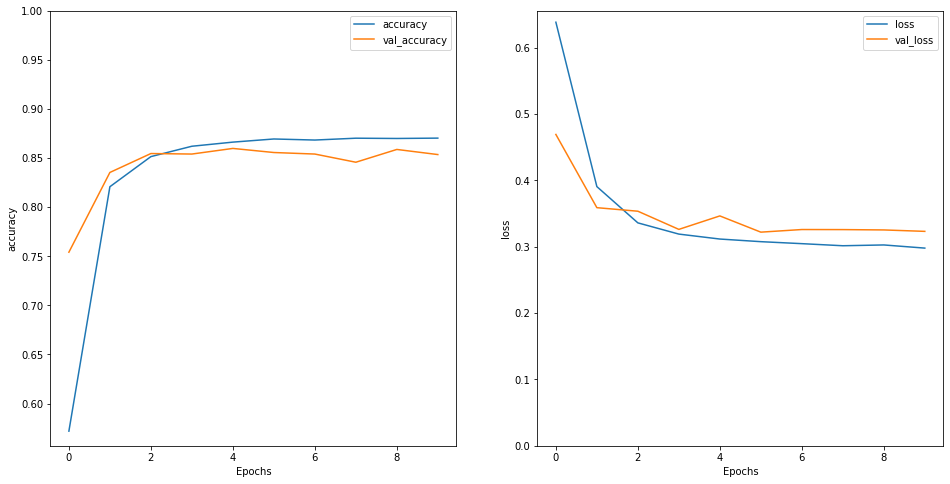

In [15]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence: If the prediction is >= `0.0`, it is positive else it is negative.

In [22]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

#### Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.
* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](images/layered-bidirectional.png)

The interesting thing about using an RNN with return_sequences=True is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [28]:
model_stacked = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [29]:
model_stacked.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                      optimizer=tf.keras.optimizers.Adam(1e-4),
                      metrics=['accuracy'])

In [30]:
history = model_stacked.fit(train_dataset, epochs=10,
                            validation_data=test_dataset,
                            validation_steps=30)

Epoch 1/10
391/391 [==============================] - 51s 102ms/step - loss: 0.6767 - accuracy: 0.5174 - val_loss: 0.4042 - val_accuracy: 0.8104
Epoch 2/10
391/391 [==============================] - 37s 95ms/step - loss: 0.3940 - accuracy: 0.8181 - val_loss: 0.3428 - val_accuracy: 0.8448
Epoch 3/10
391/391 [==============================] - 38s 96ms/step - loss: 0.3413 - accuracy: 0.8524 - val_loss: 0.3365 - val_accuracy: 0.8552
Epoch 4/10
391/391 [==============================] - 38s 96ms/step - loss: 0.3152 - accuracy: 0.8665 - val_loss: 0.3207 - val_accuracy: 0.8589
Epoch 5/10
391/391 [==============================] - 37s 94ms/step - loss: 0.3160 - accuracy: 0.8646 - val_loss: 0.3220 - val_accuracy: 0.8552
Epoch 6/10
391/391 [==============================] - 37s 95ms/step - loss: 0.3057 - accuracy: 0.8708 - val_loss: 0.3183 - val_accuracy: 0.8568
Epoch 7/10
391/391 [==============================] - 38s 96ms/step - loss: 0.3057 - accuracy: 0.8689 - val_loss: 0.3213 - val_accuracy

In [31]:
test_loss, test_acc = model_stacked.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 17s 43ms/step - loss: 0.3178 - accuracy: 0.8608
Test Loss: 0.31777849793434143
Test Accuracy: 0.860759973526001


In [32]:
sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model_stacked.predict(np.array([sample_text]))
print(predictions)

[[-1.3413177]]


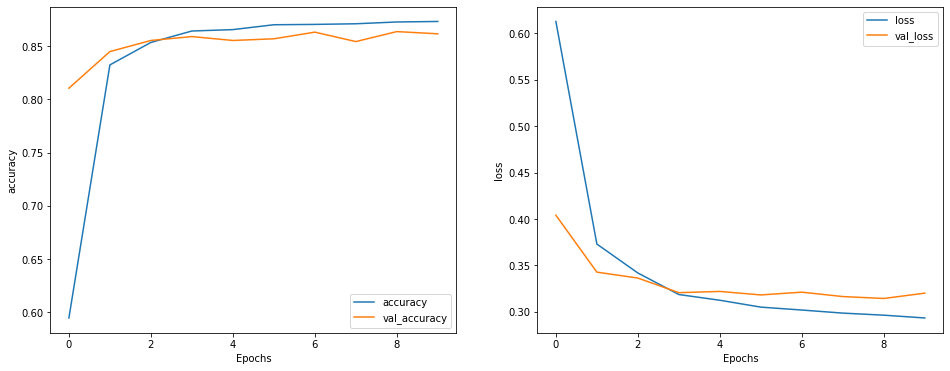

In [33]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')